In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class MetricsAnalysis:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = self.load_data()
    
    def load_data(self):
        df = pd.read_csv(self.file_path, index_col=0)
        df.fillna(0, inplace=True)  
        return df
    
    def standalone_data(self):
        return self.df.loc[["q#", "qmod", "qasm"], :] 
    
    def hosted_data(self):
        return self.df.loc[["cirq", "qapl", "qiskit", "qrisp"], :] 
       
    def plot_metrics(self, data: dict, filter: str='all', palette="viridis"):
        df = self.df.copy()
        if filter == 'hosted':
            df = self.hosted_data()
        elif filter == 'standalone':
            df = self.standalone_data() 
        plt.figure(figsize=(10, 4))
        ax = df.T.plot(kind='bar', figsize=(10, 4), colormap=palette, title=data['title'])
        ax.legend(title="Implementaciones", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel(data['xlabel'])
        plt.ylabel(data['ylabel'])
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()


    def compare_against(self, reference: str, palette="coolwarm"):
        if reference not in self.df.index:
            raise ValueError(f"{reference} no encontrado en los datos.")
        
        fig, ax = plt.subplots(figsize=(12, 6))
        df_compare = self.df.div(self.df.loc[reference])  # Normalizar respecto a la referencia
        df_compare.drop(index=reference, inplace=True)  # Remover la referencia para que no se compare consigo misma
        
        # Gráfico de líneas con puntos
        for lang in df_compare.index:
            ax.plot(df_compare.columns, df_compare.loc[lang], marker='o', label=lang)
        
        ax.axhline(1, color='gray', linestyle='--', alpha=0.7)
        ax.set_title(f"Comparación Normalizada: Lenguajes vs {reference}")
        ax.set_xlabel("Algoritmos")
        ax.set_ylabel("Ratio respecto a {reference}")
        ax.legend(title="Lenguajes")
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()        
        plt.tight_layout()
        plt.show()

    def compare_against2(self, reference: str, palette="coolwarm"):
        if reference not in self.df.index:
            raise ValueError(f"{reference} no encontrado en los datos.")
        
        fig, ax = plt.subplots(figsize=(12, 6))
        df_compare = self.df.div(self.df.loc[reference]) 
        df_compare.drop(index=reference, inplace=True)  
        
        # Graphics
        for lang in df_compare.index:
            ax.plot(df_compare.columns, df_compare.loc[lang], marker='o', label=lang)
        
        ax.axhline(1, color='gray', linestyle='--', alpha=0.7)
        ax.set_title(f"Comparación Normalizada: Lenguajes vs {reference}")
        ax.set_xlabel("Algoritmos")
        ax.set_ylabel(f"Ratio respecto a {reference}")
        ax.legend(title="Lenguajes")
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

<Figure size 1000x400 with 0 Axes>

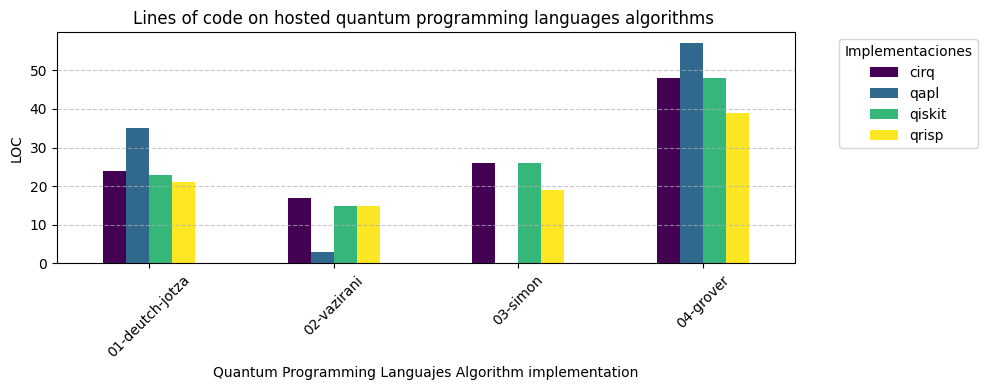

In [6]:
analysis = MetricsAnalysis("results/loc.csv")
# data can be hosted, standalone, all

analysis.plot_metrics({
    'title':'Lines of code on hosted quantum programming languages algorithms ',
    'xlabel':'Quantum Programming Languajes Algorithm implementation',
    'ylabel': 'LOC',
    'kind':'bar'
    
    }, filter='hosted')

<Figure size 1000x400 with 0 Axes>

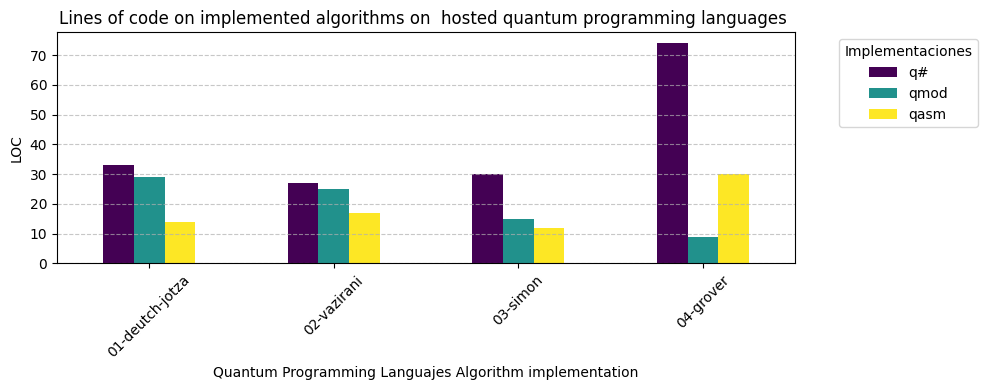

In [7]:
#analysis = MetricsAnalysis("results/loc.csv")
# data can be hosted, standalone, all

analysis.plot_metrics({
    'title':'Lines of code on implemented algorithms on  hosted quantum programming languages ',
    'xlabel':'Quantum Programming Languajes Algorithm implementation',
    'ylabel': 'LOC',
    'kind':'bar'
    
    }, filter='standalone')

<Figure size 1000x400 with 0 Axes>

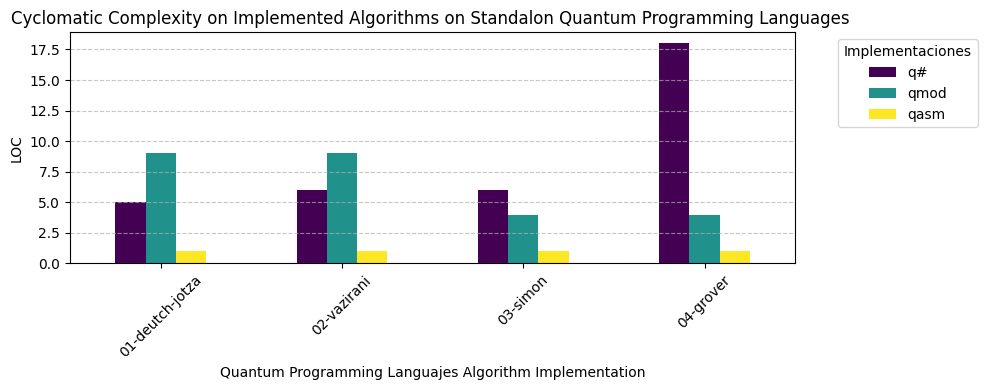

In [9]:
analysis = MetricsAnalysis("results/cyclomatic_complexity_calculator.csv")
analysis.plot_metrics({
    'title':'Cyclomatic Complexity on Implemented Algorithms on Standalon Quantum Programming Languages ',
    'xlabel':'Quantum Programming Languajes Algorithm Implementation',
    'ylabel': 'LOC',
    'kind':'bar'
    
    }, filter='standalone')

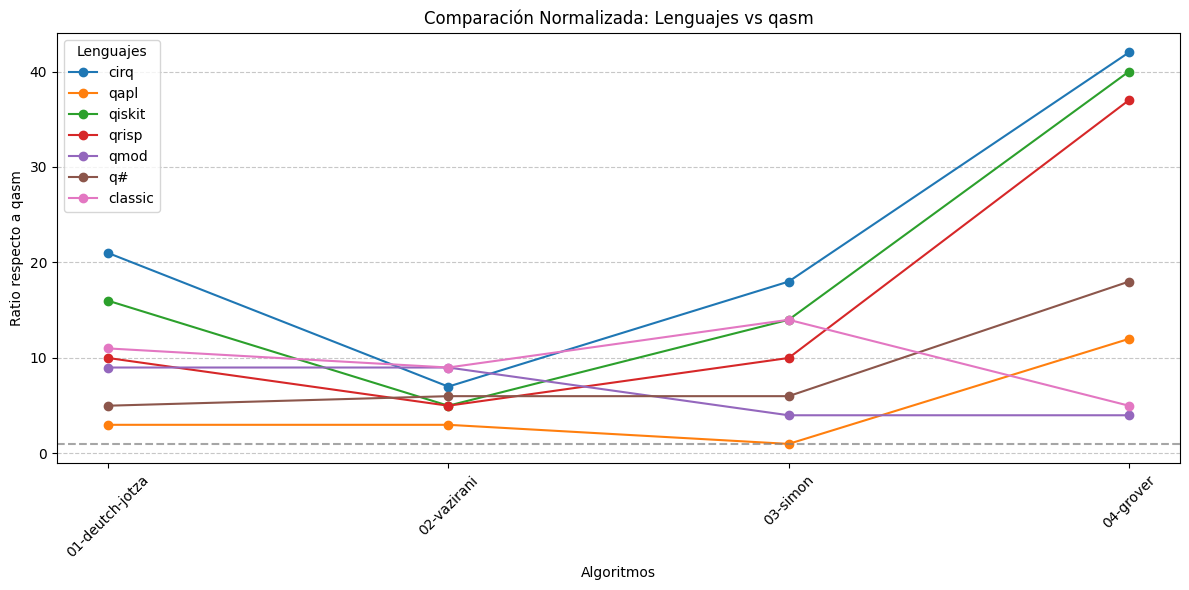

In [10]:
analysis.compare_against2("qasm")

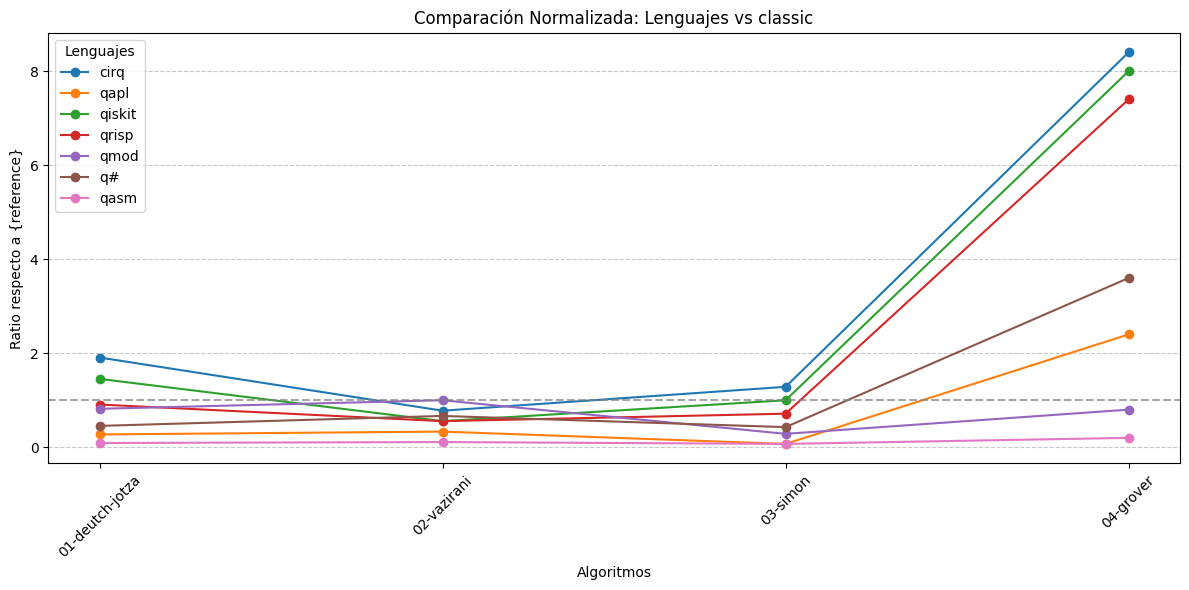

<Figure size 640x480 with 0 Axes>

In [11]:
analysis.compare_against("classic")